In [60]:
from sklearn.metrics.pairwise import pairwise_kernels, rbf_kernel
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.optimize import minimize
import numpy as np
from cvxopt import matrix, solvers

from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import Normalizer, MaxAbsScaler

In [61]:
kernel = "rbf"

# Fit

In [62]:
y1 =pd.read_excel(r'Data1.xlsx').set_index("fecha").loc["2007-01-01":"2020-03-30"]
X1 = pd.read_csv("X.csv")

X = X1.drop(["fecha"], axis = 1).to_numpy(); y = y1.to_numpy()

# scaler1 = MaxAbsScaler(); scaler1.fit(y); y = scaler1transform(y)

X, X_test, y, y_test = train_test_split(X, y, test_size = 40, shuffle = False)

scaler = MaxAbsScaler(); scaler.fit(X); X = scaler.transform(X)
X_test = scaler.transform(X_test)

scaler1 = MaxAbsScaler(); scaler1.fit(y); y = scaler1.transform(y).reshape(-1)
y_test = scaler1.transform(y_test).reshape(-1)

In [63]:
ydim = y.shape[0]
epsilon = 5 # margin max
C = 0.5 # alphas constraint
error = 1E-1 # vector support 
x0 = np.random.rand(ydim) # random initialization

K = pairwise_kernels(X, X, metric = kernel)

In [64]:
# A = np.array(np.ones.reshape(1, -1), dtype = "float64")
onev = np.ones((ydim,1))
A = onev.T
b = 0.0
G = np.concatenate((np.identity(ydim), -np.identity(ydim)))
h_ = np.concatenate((100*C*np.ones(ydim)/y, 100*C*np.ones(ydim)/y)); 
h = h_.reshape(-1, 1)

In [65]:
A = matrix(A)
b = matrix(b)
G = matrix(G)
h = matrix(h)

In [66]:
def obj_func(x):
    eps_con = (epsilon*y.T)/100
    return 0.5* x.T @ K @ x + eps_con @ (np.abs(x)) - y.T @ x

def obj_grad(x):
    eps_con = (epsilon*y.T)/100
    return x.T @ K + eps_con @ (x/np.abs(x)) - y

def obj_jes(x):
    return K  

In [67]:
def F(x = None, z = None):
    if x is None: return 0, matrix(x0)
    val = obj_func(x)
    val_ = matrix(val)
    
    dif = obj_grad(x)
    dif_ = matrix(dif)
#     return val, Df.T
    if z is None: return val_, dif_
    H = matrix(z[0] * K)
    return val_, dif_, H

In [68]:
# opts = {'maxiters' : 100, 'verbose':1, 'abstol':1e-20, 'reltol':1e-20}, options = opts

In [69]:
# import mosek
# solvers.options['mosek'] = {mosek.iparam.log: 0}
# solvers.options['glpk'] = {'msg_lev' : 'GLP_MSG_OFF'}

In [70]:
sol = solvers.cp(F=F, G=G, h=h, A=A, b=b)

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  1.9203e+06  1e+04  1e+00  1e+00
 1: -2.5273e+04  2.2636e+06  6e+03  1e+00  1e+00
 2: -7.4894e+04  2.3716e+06  3e+03  1e+00  1e+00
 3: -1.6102e+05  2.2668e+06  1e+03  1e+00  9e-01
 4: -2.6586e+05  2.0760e+06  8e+02  9e-01  9e-01
 5: -3.9138e+05  1.8282e+06  6e+02  9e-01  8e-01
 6: -5.2718e+05  1.5309e+06  4e+02  8e-01  7e-01
 7: -6.3224e+05  1.2587e+06  4e+02  8e-01  7e-01
 8: -7.2696e+05  9.5193e+05  3e+02  7e-01  6e-01
 9: -7.7392e+05  6.8248e+05  3e+02  6e-01  5e-01
10: -7.6822e+05  4.3510e+05  2e+02  5e-01  4e-01
11: -6.9700e+05  2.4615e+05  2e+02  4e-01  3e-01
12: -5.6295e+05  1.1506e+05  1e+02  3e-01  2e-01
13: -3.8559e+05  4.1814e+04  9e+01  2e-01  1e-01
14: -2.4707e+05  1.7119e+04  6e+01  1e-01  7e-02
15: -1.3298e+05  7.7693e+03  4e+01  6e-02  4e-02
16: -4.8579e+04  5.4260e+03  2e+01  2e-02  1e-02
17: -1.8198e+04  5.3319e+03  8e+00  9e-03  6e-03
18: -4.8177e+03  5.3971e+03  4e+00  4e-03  2e-03
19:  2.3579e+03  5.46

In [71]:
np.array(sol["y"])

array([[-9.11201417]])

# Predict

## get coefficients

In [72]:
solution = np.array(sol["x"]).reshape(-1)

In [73]:
# tol = np.quantile(np.abs(solution), 0.1)
# index = (~np.isclose(solution, 0, atol = tol)).tolist()
index = abs(solution) > error

In [74]:
alpha_sv = solution[index]
y_sv = y[index]
x_sv = X[index, :]

In [75]:
K_sv = pairwise_kernels(x_sv, x_sv, metric = kernel)
w_phi = alpha_sv @ K_sv

In [76]:
sum(alpha_sv)

1.2993671084871039e-05

In [77]:
const = np.where(alpha_sv >= 0, 1 - epsilon/100, 1 + epsilon/100)
b = np.mean(y_sv*const - w_phi)

## Predict new data

In [78]:
K_pred = pairwise_kernels(x_sv, X_test, metric = kernel)

In [79]:
w_phi_pred = alpha_sv.T @ K_pred
y_pred = w_phi_pred + b

In [80]:
# rbf kernel

2.0399074413133107


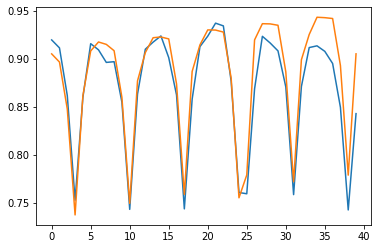

In [81]:
print(np.mean(np.abs((y_pred - y_test))/y_test)*100)
plt.plot(y_test)
plt.plot(y_pred)

In [ ]:
# linear kernel

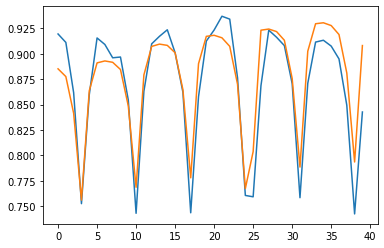

In [58]:
plt.plot(y_test)
plt.plot(y_pred)

In [59]:
print(np.mean(np.abs((y_pred - y_test))/y_test)*100)

2.2799082638061527
